# Read 10X and create tiles

In [1]:
import stlearn as st
st.settings.set_figure_params(dpi=300)
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import sys
from pathlib import Path
from typing import Optional, Union
from anndata import AnnData
import pandas as pd
import stlearn
from typing import Optional, Union
from anndata import AnnData
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import numpy as np
import os


def tiling(
        adata: AnnData,
        out_path: Union[Path, str] = "./tiling",
        library_id: str = None,
        crop_size: int = 40,
        target_size: int = 299,
        verbose: bool = False,
        copy: bool = False,
) -> Optional[AnnData]:
    

    if library_id is None:
        library_id = list(adata.uns["spatial"].keys())[0]

    # Check the exist of out_path
    if not os.path.isdir(out_path):
        os.mkdir(out_path)

    image = adata.uns["spatial"][library_id]["images"][adata.uns["spatial"]["use_quality"]]
    if image.dtype == np.float32 or image.dtype == np.float64:
        image = (image * 255).astype(np.uint8)
    img_pillow = Image.fromarray(image)
    tile_names = []

    with tqdm(
            total=len(adata),
            desc="Tiling image",
            bar_format="{l_bar}{bar} [ time left: {remaining} ]",
    ) as pbar:
        for imagerow, imagecol in zip(adata.obs["imagerow"], adata.obs["imagecol"]):
            imagerow_down = imagerow - crop_size / 2
            imagerow_up = imagerow + crop_size / 2
            imagecol_left = imagecol - crop_size / 2
            imagecol_right = imagecol + crop_size / 2
            tile = img_pillow.crop(
                (imagecol_left, imagerow_down, imagecol_right, imagerow_up)
            )
            # tile.thumbnail((target_size, target_size), Image.ANTIALIAS)
            tile = tile.resize((target_size, target_size))
            tile_name = library_id + "-" + str(imagecol) + "-" + str(imagerow) + "-" + str(crop_size)#np.arange(len(pd.Series(adata))+1).astype(str).str.zfill(4)+1 + "-" +
            out_tile = Path(out_path) / (tile_name + ".jpeg")
            tile_names.append(str(out_tile))
            if verbose:
                print(
                    "generate tile at location ({}, {})".format(
                        str(imagecol), str(imagerow)
                    )
                )
            tile.save(out_tile, "JPEG")

            pbar.update(1)

    adata.obs["tile_path"] = tile_names
    return adata if copy else None

# Loading Visium Data and Image Tilling

In [2]:
BASE_PATH = Path("D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files")
TILE_PATH = BASE_PATH / "tiles"
TILE_PATH.mkdir(parents=True, exist_ok=True)


SAMPLE = "block1"
Sample1 = st.Read10X(BASE_PATH / SAMPLE, 
                  library_id=SAMPLE, 
                  count_file="V1_Breast_Cancer_Block_A_Section_1_filtered_feature_bc_matrix.h5",
                  quality="fulres",)
img = plt.imread(BASE_PATH / SAMPLE /"V1_Breast_Cancer_Block_A_Section_1_image.tif", 0)
Sample1.uns["spatial"][SAMPLE]['images']["fulres"] = img


SAMPLE = "block2"
Sample2 = st.Read10X(BASE_PATH / SAMPLE, 
                  library_id=SAMPLE, 
                  count_file="V1_Breast_Cancer_Block_A_Section_2_filtered_feature_bc_matrix.h5",
                  quality="fulres",)
                  #source_image_path=BASE_PATH / SAMPLE /"V1_Breast_Cancer_Block_A_Section_1_image.tif")
img = plt.imread(BASE_PATH / SAMPLE /"V1_Breast_Cancer_Block_A_Section_2_image.tif", 0)
Sample2.uns["spatial"][SAMPLE]['images']["fulres"] = img


for adata in [Sample1,Sample2,]:

    st.pp.normalize_total(adata)
    TILE_PATH_ = TILE_PATH / list(adata.uns["spatial"].keys())[0]
    TILE_PATH_.mkdir(parents=True, exist_ok=True)
    tiling(adata, TILE_PATH_, crop_size=299)
    #st.pp.extract_feature(adata)
    
"""Sample1.obs.iloc[:,4:] #Link_to_img
Sample2.obs.iloc[:,4:] #Link_to_img

Sample1.to_df()[Sample1.to_df().sum().sort_values(ascending=False).index[:500]] #top-500-genes 
Sample2.to_df()[Sample2.to_df().sum().sort_values(ascending=False).index[:500]] #top-500-genes"""
#

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Normalization step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]


Normalization step is finished in adata.X


Tiling image: 100%|██████████ [ time left: 00:00 ]


'Sample1.obs.iloc[:,4:] #Link_to_img\nSample2.obs.iloc[:,4:] #Link_to_img\n\nSample1.to_df()[Sample1.to_df().sum().sort_values(ascending=False).index[:500]] #top-500-genes \nSample2.to_df()[Sample2.to_df().sum().sort_values(ascending=False).index[:500]] #top-500-genes'

## ResNet50 Features

In [ ]:
import os; import pandas as pd; import numpy as np
import PIL; from PIL import Image
PIL.Image.MAX_IMAGE_PIXELS = 933120000
import os; import glob
from PIL import Image; import matplotlib.pyplot as plt; 
from keras.utils import np_utils
from keras.models import Sequential
from keras.applications import VGG16, ResNet50, inception_v3, DenseNet121
from keras.applications import imagenet_utils
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.layers import Dense, Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, GlobalAveragePooling2D
import warnings

wd = "D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files"
def ResNet50_features_train(train, pre_model):
 
    x_scratch_train = []
        for imagePath in train:
        image = load_img(imagePath, target_size=(299,299))
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)
        x_scratch_train.append(image)
        
    x_train = np.vstack(x_scratch_train)
    features_train = pre_model.predict(x_train, batch_size=32)
    features_flatten_train = features_train.reshape((features_train.shape[0], 2048))
    features_flatten_train = pd.DataFrame(features_flatten_train)
    #Sample1.obsm["ResNet50_features"] = features_flatten_train
    return features_flatten_train

def ResNet50_features_test(test, pre_model):
    
    x_scratch_test = []
    for imagePath in test:
        image = load_img(imagePath, target_size=(299,299))
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)
        x_scratch_test.append(image)

    x_test = np.vstack(x_scratch_test)
    features_test = pre_model.predict(x_test, batch_size=32)
    features_flatten_test = features_test.reshape((features_test.shape[0], 2048))
    features_flatten_test = pd.DataFrame(features_flatten_test)
    #Sample2.obsm["ResNet50_features"] = features_flatten_test
    
    return features_flatten_test
    
train = Sample1.obs["tile_path"]
test = Sample2.obs["tile_path"]
model = ResNet50(weights="imagenet", include_top=False, input_shape=(299,299, 3), pooling="avg")

Train_Features = ResNet50_features_train(train, model)
Test_Features = ResNet50_features_test(test, model)

## Cancer vs Non-Cancer Spot

In [6]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from numpy import asarray
from os import listdir
import pandas as pd
import numpy as np
from sklearn.cluster import AgglomerativeClustering


def Clusters(Sample1_tiles, Sample2_tiles, model):
    
    Sample1_to_df = Sample1.to_df().reset_index(drop=True)
    Sample1_to_df.drop([col for col, val in Sample1_to_df.sum().iteritems() if val < 20000], axis=1, inplace=True)

    Sample2_to_df = Sample2.to_df().reset_index(drop=True)
    Sample2_to_df.drop([col for col, val in Sample2_to_df.sum().iteritems() if val < 20000], axis=1, inplace=True)
    
    photos_Sample1, photos_Sample2 =list(), list()
    for filename in Sample1_tiles:
            # load image
            photo = load_img(filename, target_size=(140,140))
            # convert to numpy array
            photo = img_to_array(photo, dtype='uint8')
            # store
            photos_Sample1.append(photo)
    
    Img_Sample1 = asarray(photos_Sample1, dtype='uint8')
    Img_Sample1 = pd.DataFrame(Img_Sample1.reshape(Img_Sample1.shape[0],58800))
    result_Sample1 = pd.concat([Img_Sample1, Sample1_to_df], axis=1)
    y_hc_Sample1 = pd.DataFrame(index = Sample1.obs.index)
    y_hc_Sample1["Cluster"] = model.fit_predict(result_Sample1)
    Sample1.obs["Cluster"] = y_hc_Sample1["Cluster"]
    

    for filename in Sample2_tiles:
            # load image
            photo = load_img(
                filename, target_size=(140,140))
            # convert to numpy array
            photo = img_to_array(photo, dtype='uint8')
            # store
            photos_Sample2.append(photo)

    Img_Sample2 = asarray(photos_Sample2, dtype='uint8')
    Img_Sample2 =  pd.DataFrame(Img_Sample2.reshape(Img_Sample2.shape[0],58800))
    result_Sample2 =  pd.concat([Img_Sample2, Sample2_to_df], axis=1)
    y_hc_Sample2 = pd.DataFrame(index = Sample2.obs.index)
    y_hc_Sample2["Cluster"] = model.fit_predict(result_Sample2)
    Sample2.obs["Cluster"] = y_hc_Sample2["Cluster"]
    
model = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage = 'ward')
Sample1_tiles = Sample1.obs["tile_path"]
Sample2_tiles = Sample2.obs["tile_path"]

Clusters(Sample1_tiles, Sample2_tiles, model)

## Cancer and Non-Cancer Spots Visualisation in Visualization.py

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

image = cv2.imread("D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files/block1/V1_Breast_Cancer_Block_A_Section_1_image.tif") 
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
Spot_vals0=Sample1.obs[Sample1.obs['Cluster'] == 0]
Spot_vals0=Spot_vals0.values
Spot_vals1=Sample1.obs[Sample1.obs['Cluster'] == 1]
Spot_vals1=Spot_vals1.values

x = Spot_vals0[:,4].astype('int64')
y = Spot_vals0[:,5].astype('int64')
box = (x,y)
numpy_array = np.array(box)
transpose = numpy_array.T
box = transpose.tolist()
x1 = Spot_vals1[:,4].astype('int64')
y1 = Spot_vals1[:,5].astype('int64')
box1 = (x1,y1)
numpy_array1 = np.array(box1)
transpose1 = numpy_array1.T
box1 = transpose1.tolist()

for i in range(0,len(box)):
    image=cv2.circle(image, tuple(box[i]), 50,(255,0,0), -1)
for i in range(0,len(box1)):
    image=cv2.circle(image, tuple(box1[i]), 50,(0,255,0), -1)
cv2.imwrite("D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files/Cancer_vs_Non-Cancer_New_trial_train.png",image)

## UMAP Non-Cancer vs Cancer - Resnet50 Features - model.py

<AxesSubplot:>

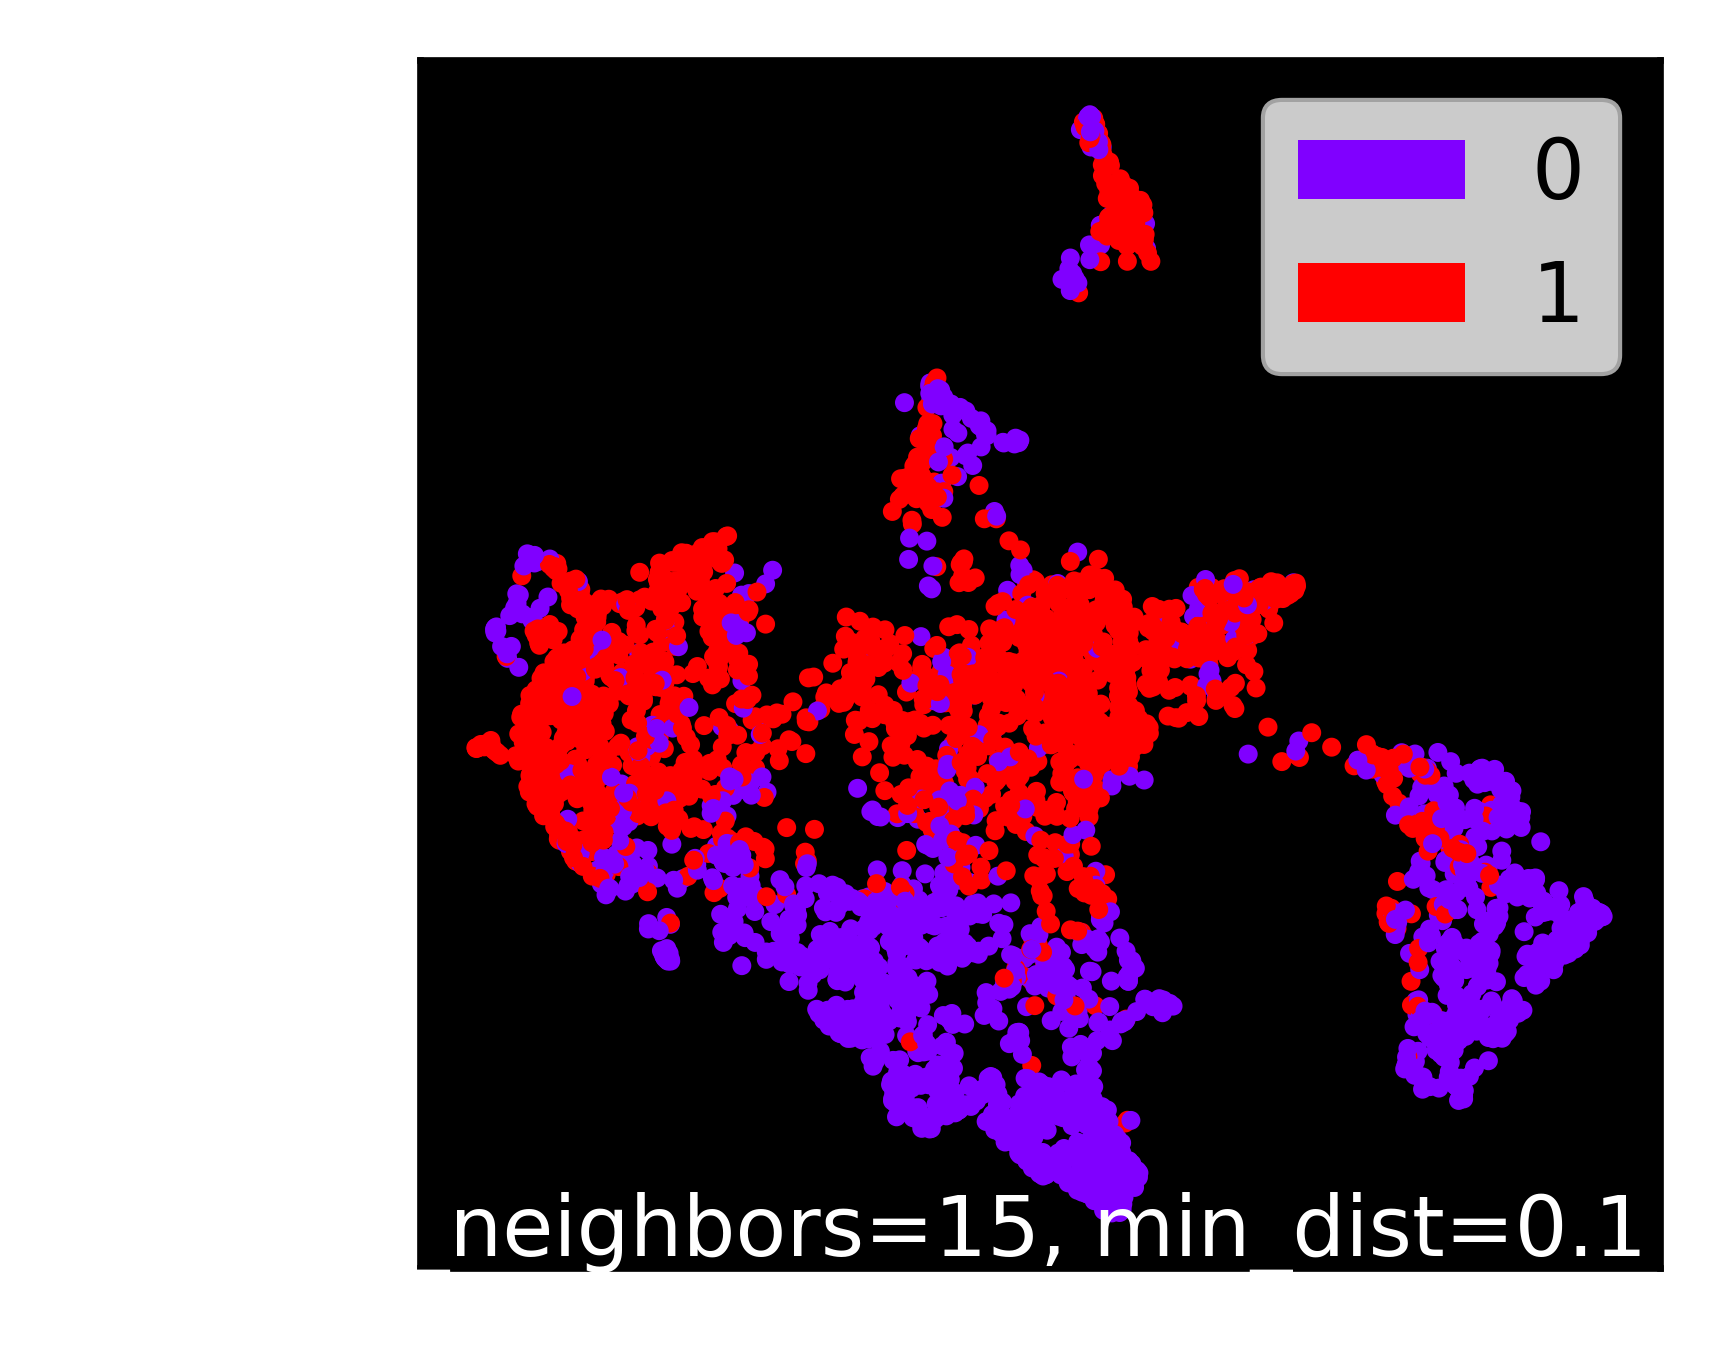

In [24]:
import pandas as pd
import datashader as ds
import datashader.transfer_functions as tf
import datashader.bundling as bd
import matplotlib.pyplot as plt
import colorcet
import matplotlib.colors
import matplotlib.cm
import bokeh.plotting as bpl
import bokeh.transform as btr
import holoviews as hv
import holoviews.operation.datashader as hd
import umap.plot

def Umap_points(resnet_features, label):
    
    mapper = umap.UMAP().fit(resnet_features)
    return umap.plot.points(mapper, labels=label, theme='fire', background='black')

resnet_features = Train_Features.values
label = Sample1.obs["Cluster"].values
Umap_points(resnet_features, label)

## Cancer and Non-Cancer Spot Prediction by Biomarkers - model.py

Confusion matrix

 [[1214  718]
 [ 367 1688]]
AUROC-Score: 0.7248877907240332


 97%|=================== | 3877/3987 [00:26<00:00]       

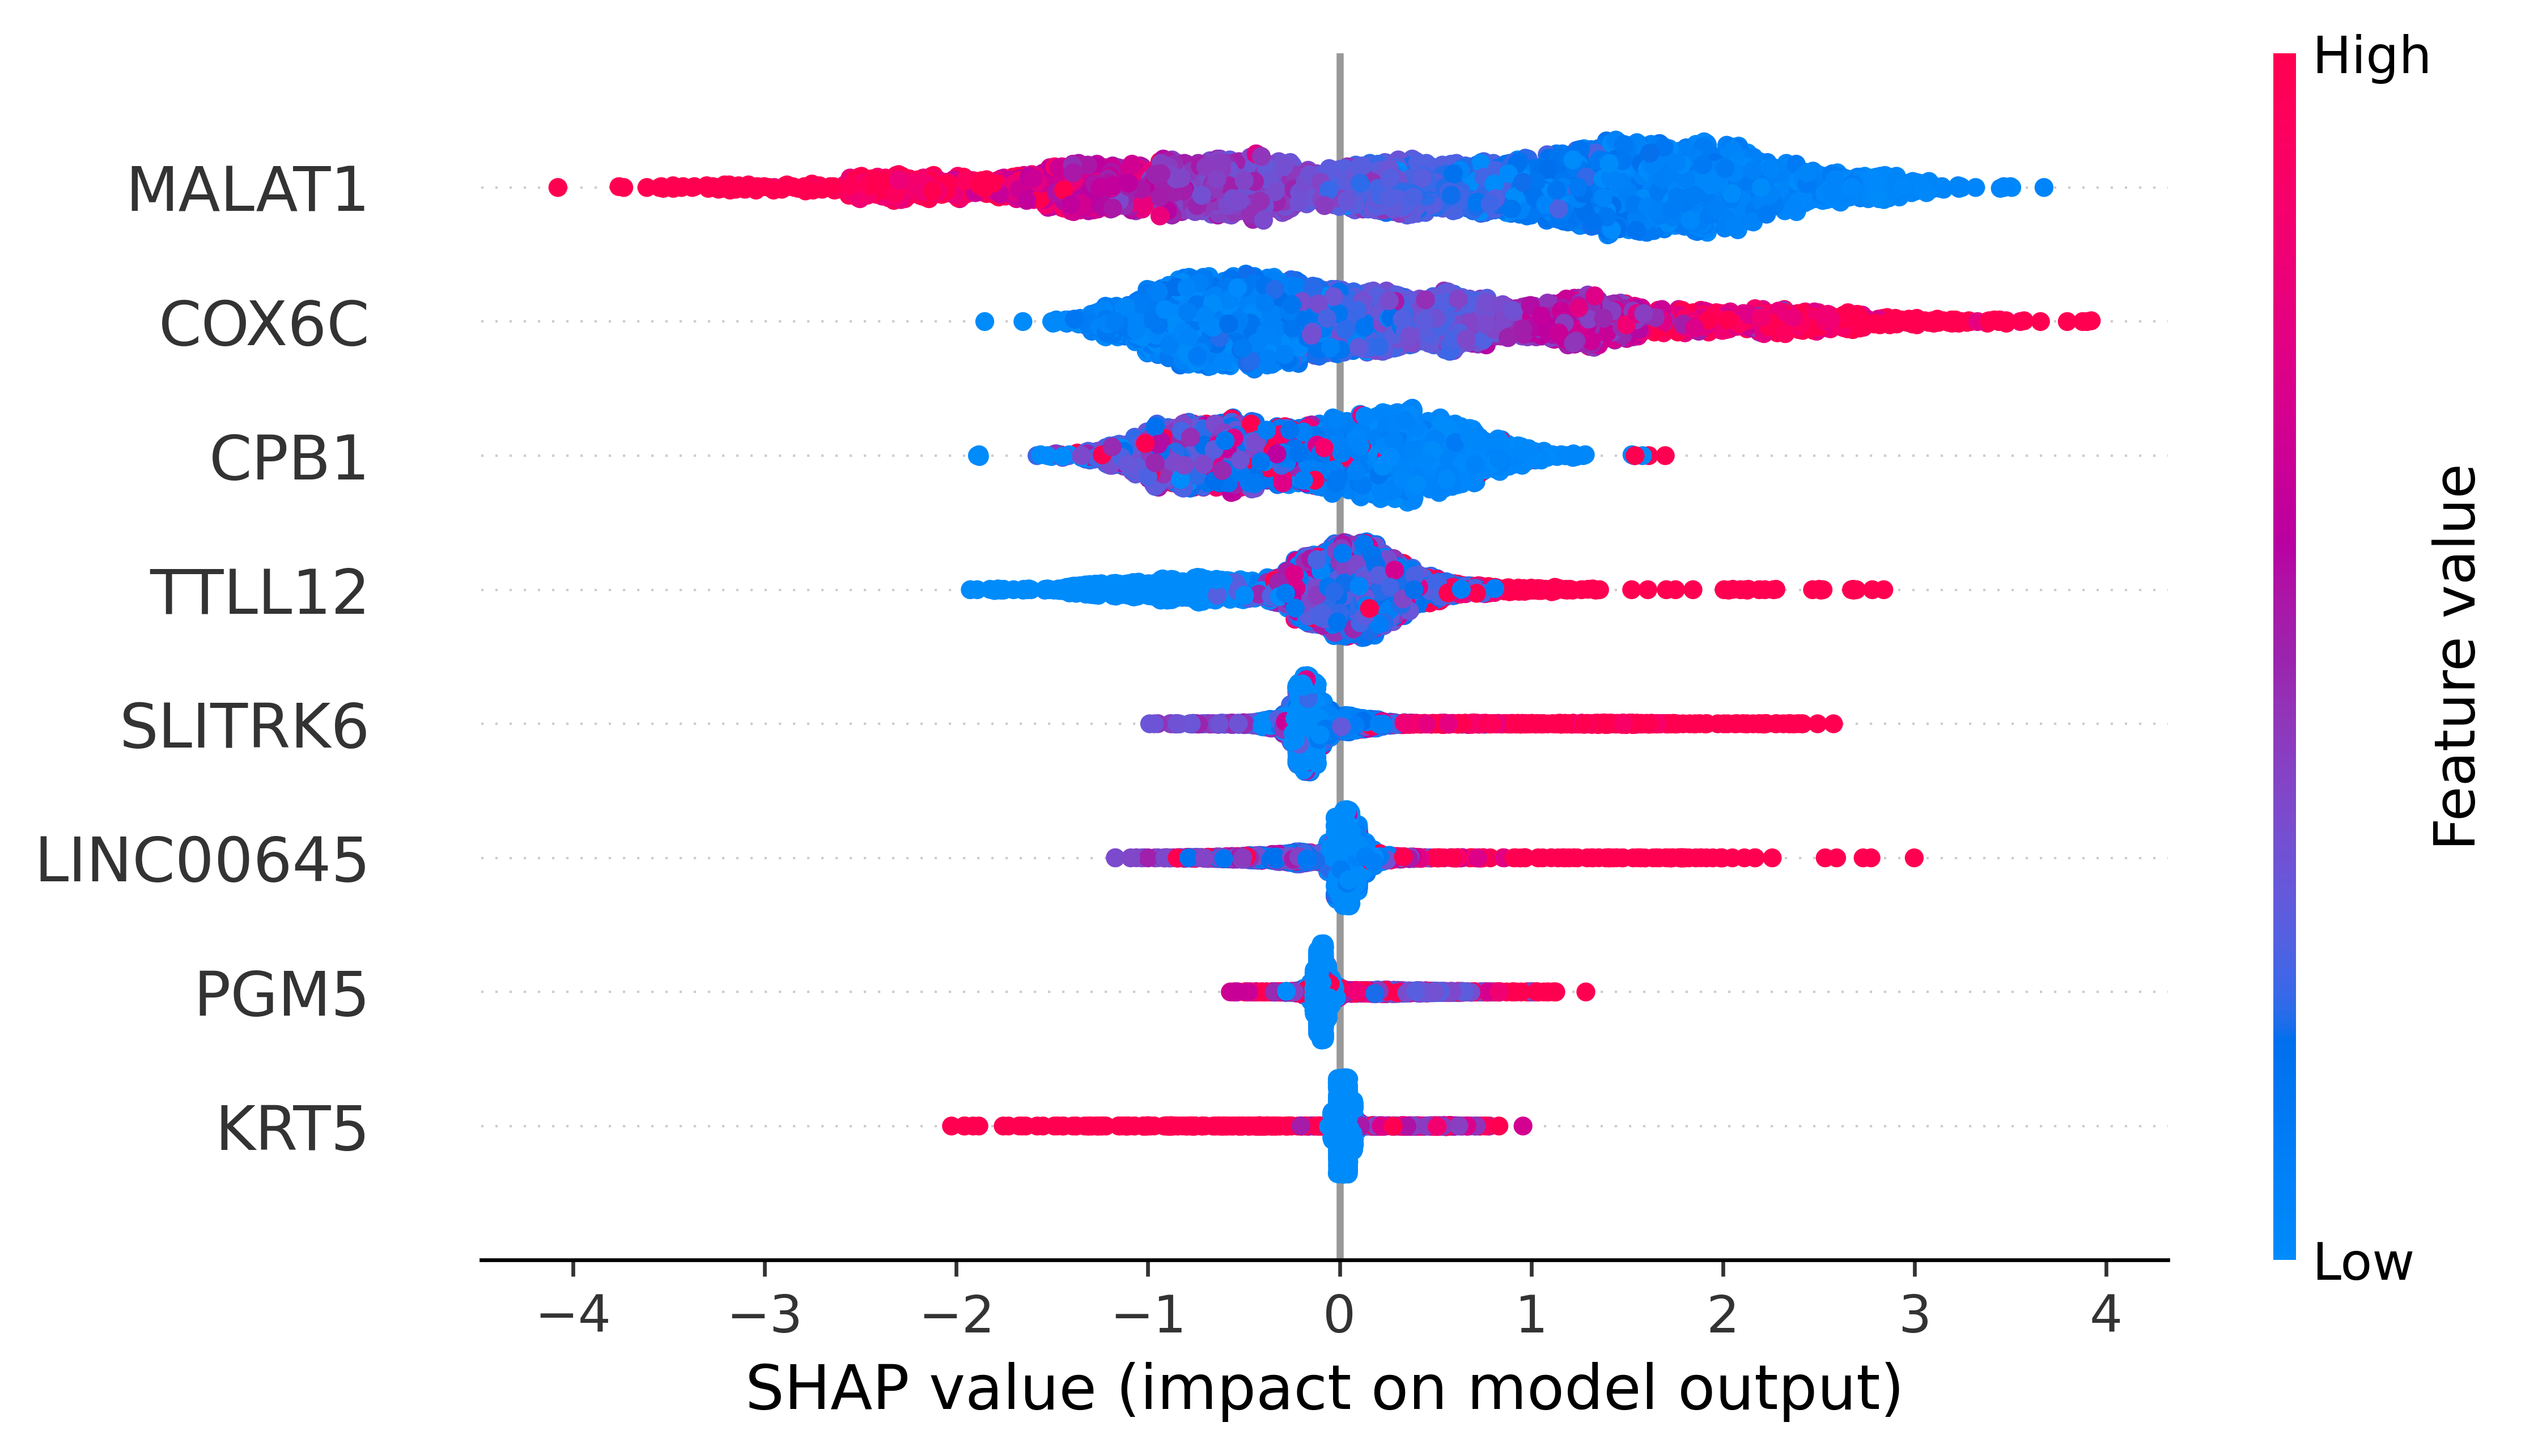

Intercept 0.42337075339181995
Prediction_local [0.86824733]
Right: 0.906353712077117


In [43]:
import pandas as pd
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer
import shap
import numpy as np
import lime
import lime.lime_tabular
    
def multiclass_roc_auc_score(truth, pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(truth)
    truth = lb.transform(truth)
    pred = lb.transform(pred)
    return roc_auc_score(truth, pred, average=average)

def Can_pred_Biomarker(Biomarkers_train, Cluster_train, Biomarkers_test, tree_model):
    X_train, X_test, y_train, y_test = train_test_split(Biomarkers_train, Cluster_train, test_size = 0.15, random_state = 0, stratify=Cluster_train)
    clf = tree_model
    clf.fit(X_train, y_train)
    return clf, clf.predict(Biomarkers_test)

def Shapley_plot(Biomarkers_train, Biomarkers_test, clf):
    shap.initjs()
    explainer = shap.TreeExplainer(clf, Biomarkers_train)
    shap_values = explainer.shap_values(Biomarkers_test)
    return shap.summary_plot(shap_values, Biomarkers_test)

def Lime_plot(Biomarkers_train):

    explainer = lime.lime_tabular.LimeTabularExplainer(np.array(Biomarkers_train),
                        feature_names=Biomarkers_train.columns, 
                        class_names=['0','1'],                            
                        verbose=True, mode='classification')
    return explainer


    
Biomarkers_train = Sample1.to_df()[['COX6C','MALAT1','TTLL12','PGM5','KRT5','LINC00645','SLITRK6', 'CPB1']]
Cluster_train = Sample1.obs["Cluster"]
Biomarkers_test = Sample2.to_df()[['COX6C','MALAT1','TTLL12','PGM5','KRT5','LINC00645','SLITRK6', 'CPB1']]
Cluster_test = Sample2.obs["Cluster"]
tree_model = lgb.LGBMClassifier()

clf, y_pred_test = Can_pred_Biomarker(Biomarkers_train, Cluster_train, Biomarkers_test, tree_model)
cm = confusion_matrix(Cluster_test, y_pred_test)
print('Confusion matrix\n\n', cm)
multiclass_roc_score = multiclass_roc_auc_score(Cluster_test, y_pred_test, average="weighted")
print('AUROC-Score:', multiclass_roc_score)

Shapley_plot(Biomarkers_train, Biomarkers_test, clf)
explainer = Lime_plot(Biomarkers_train)
exp = explainer.explain_instance(Biomarkers_test.iloc[2], clf.predict_proba, num_features=5)
exp.show_in_notebook(show_table=True) 

## Biomarker Identicals - model.py

 98%|===================| 3890/3987 [00:37<00:00]        

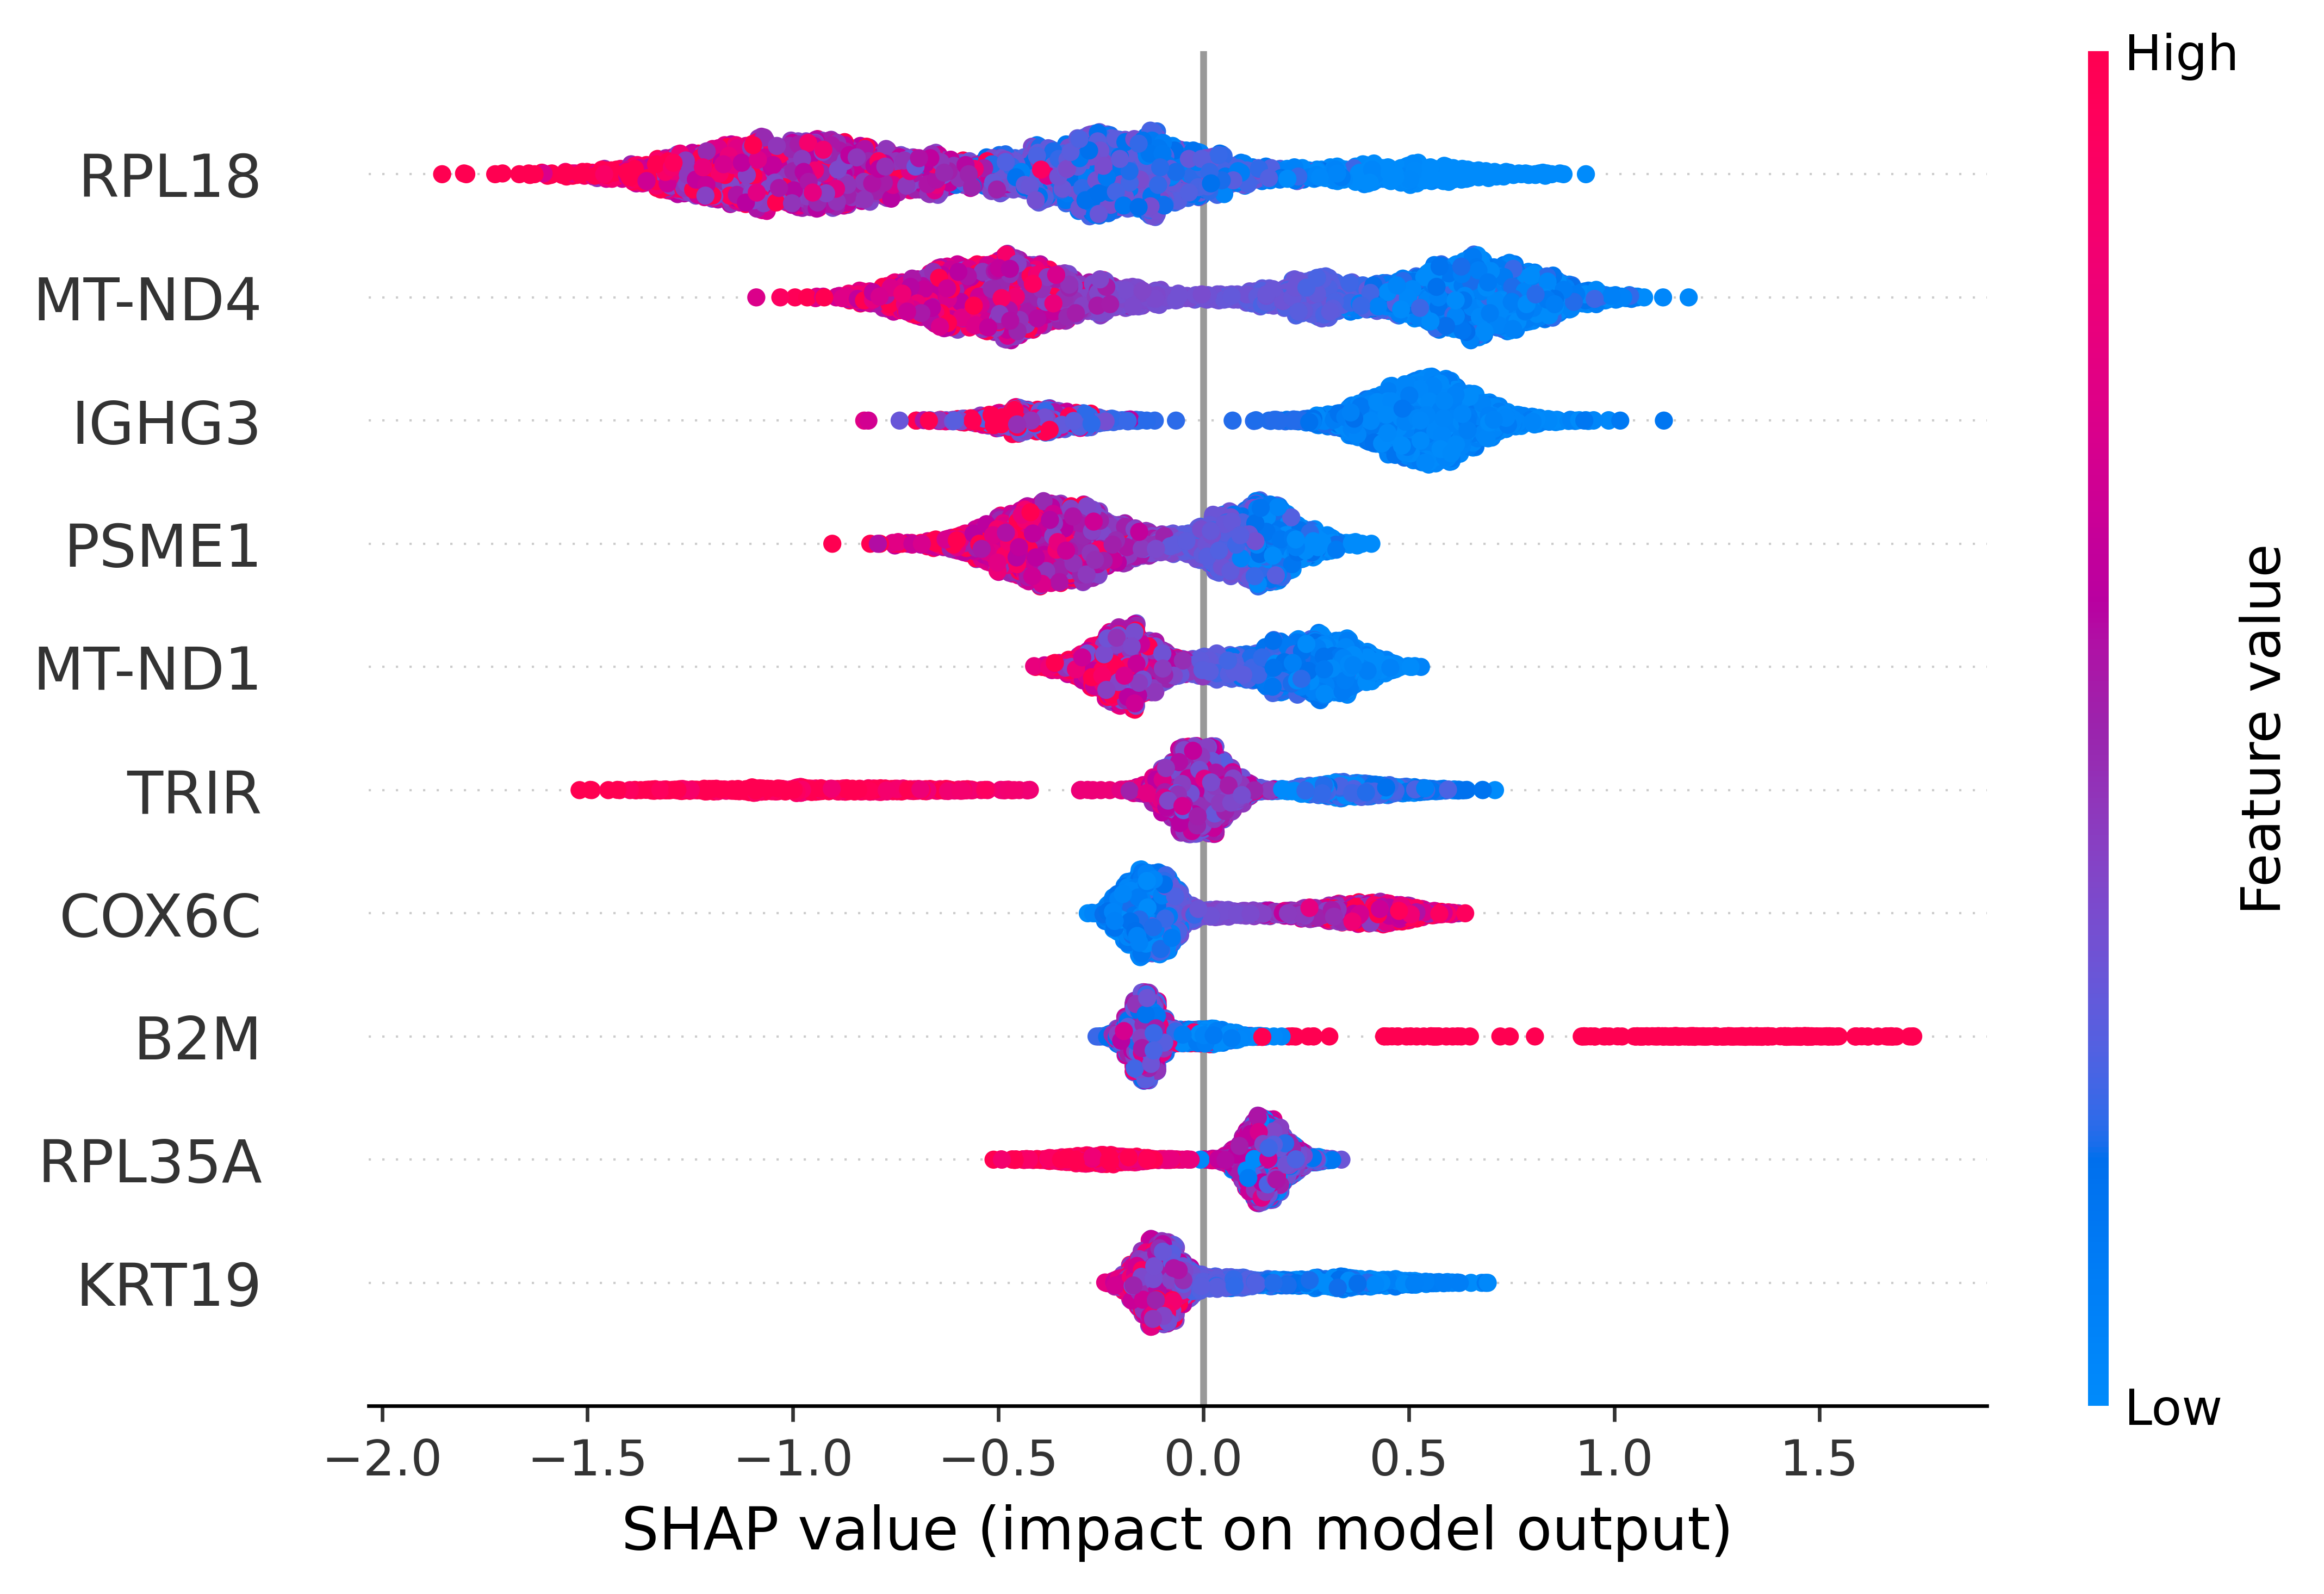

In [46]:
def Biomarker_Identicals(train_X, test_X, train_Y, test_Y, tree_model):

    X_train, X_test, y_train, y_test = train_test_split(train_X, train_Y, test_size = 0.20, random_state = 0)
    clf = tree_model
    clf.fit(X_train, y_train)
    explainer = shap.TreeExplainer(clf, X_train)
    shap_values = explainer.shap_values(test_X)
    return shap.summary_plot(shap_values, test_X, max_display=10)


train_X = Sample1.to_df()[Sample1.to_df().sum().sort_values(ascending=False).index[:500]] 
test_X = Sample2.to_df()[Sample2.to_df().sum().sort_values(ascending=False).index[:500]] 
train_Y = Sample1.obs["Cluster"] 
test_Y = Sample2.obs["Cluster"] 
tree_model = lgb.LGBMClassifier()

Biomarker_Identicals(train_X, test_X, train_Y, test_Y, tree_model)

# AUROC Score LGBM 3-Class Classification of Gene Expression - model.py

In [48]:
from sklearn.multioutput import MultiOutputClassifier
import pandas as pd
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder; from sklearn.model_selection import train_test_split
from sklearn import preprocessing; from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score; from sklearn.neighbors import KNeighborsClassifier
import pandas as pd; import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder; from sklearn.model_selection import train_test_split
from sklearn import preprocessing; from sklearn.linear_model import LogisticRegression
import shap; import numpy as np; shap.initjs()

wd = "D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files"
    
def three_class_auroc(X, test_X, Y, test_Y, number_of_genes, model):
    
    def multiclass_roc_auc_score(truth, pred, average="macro"):
        lb = LabelBinarizer()
        lb.fit(truth)
        truth = lb.transform(truth)
        pred = lb.transform(pred)
        return roc_auc_score(truth, pred, average=average)

    Y=Y.iloc[:,:number_of_genes]
    MinMax_scaler_y = preprocessing.MinMaxScaler(feature_range =(0, 1))
    Y = MinMax_scaler_y.fit_transform(Y) 
    Y = pd.DataFrame(data=Y)
    Y=Y.apply(lambda x: pd.qcut(x, 3,duplicates='drop',labels=False))
    
    #test_Y.drop(['Sno'],axis=1,inplace=True)
    test_Y=test_Y.iloc[:,:number_of_genes]
    test_Y=MinMax_scaler_y.transform(test_Y)
    test_Y=pd.DataFrame(data=test_Y)
    test_Y=test_Y.apply(lambda x: pd.qcut(x, 3,duplicates='drop',labels=False))
    
    
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.15, random_state = 0)
    clf = MultiOutputClassifier(model).fit(X_train, y_train)
    y_pred_test=clf.predict(test_X)
    y_pred_test = pd.DataFrame(y_pred_test)
    
    
    result = []
    for col in test_Y:
        score = multiclass_roc_auc_score(y_pred_test[col],test_Y[col])
        result.append(score)
        
    res = pd.DataFrame(index=[k for k in Y])
    res["AUC"] = result
    return res #res.to_csv("New_AUROC_Score_top200_genes.csv")

X = Train_Features
test_X = Test_Features
Y = Sample1.to_df()[Sample1.to_df().sum().sort_values(ascending=False).index[:500]] 
test_Y = Sample2.to_df()[Sample2.to_df().sum().sort_values(ascending=False).index[:500]] 
number_of_top_genes=2
model = lgb.LGBMClassifier()

AUROC = three_class_auroc(X, test_X, Y, test_Y, number_of_top_genes, model)

## LIME Interpretability - Interpretation.py

In [1]:
from sklearn.multioutput import MultiOutputClassifier
import pandas as pd
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import LabelBinarizer
import os
from keras.applications.imagenet_utils import decode_predictions
from keras.preprocessing import image
from sklearn.metrics import roc_auc_score
%matplotlib inline
import pandas as pd
from keras.utils import to_categorical
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import sys
from numpy import load
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras import backend
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from keras.optimizers import SGD, Adam
from keras.models import Model
from tensorflow.keras import regularizers
from keras.applications.resnet50 import ResNet50, preprocess_input
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import lime
from sklearn.preprocessing import MinMaxScaler
from lime import lime_image
from skimage.segmentation import mark_boundaries
import glob
import os
from tensorflow.keras.preprocessing import image as image_fun
from sklearn.preprocessing import OneHotEncoder

In [3]:
def LGBM(train_X, train_Y, gene): 
    train_Y = train_Y[[gene]]
    Standard_scaler_y = preprocessing.MinMaxScaler(feature_range =(0, 1))
    train_Y = pd.DataFrame(data = Standard_scaler_y.fit_transform(train_Y))
    train_Y=train_Y.apply(lambda x: pd.qcut(x, 3,duplicates='drop',labels=False))
    X_train, X_test, y_train, y_test = train_test_split(train_X, train_Y, test_size = 0.15, random_state = 0)
    clf = MultiOutputClassifier(lgb.LGBMClassifier()).fit(X_train, y_train) #LGBM model is fit for X and Y
    return clf

train_X = Train_Features #pd.read_csv('ResNet50_Trainig_Breast_1A.csv')
#train_X = train_X.iloc[:,1:]
train_Y = Sample1.to_df()[Sample1.to_df().sum().sort_values(ascending=False).index[:500]] #pd.read_csv('Breast_1A_500_top.csv')
#train_Y = train_Y.drop(['Sno'], axis=1)
gene = input('Enter Gene Name : ')
Model_LGBM = LGBM(train_X, train_Y, gene)

resnet_model = ResNet50(weights="imagenet", include_top=False, input_shape=(290,290, 3), pooling="avg")
#gene_list = train_Y.columns

def combine_model_predict(tile):
    feature = resnet_model.predict(tile)
    feature = feature.reshape((10, 2048))
    prediction = Model_LGBM.predict(feature)
    return prediction

def pred_label(tile):
    feature = resnet_model.predict(tile)
    feature = feature.reshape((1, 2048))
    prediction = Model_LGBM.predict_proba(feature)
    return prediction

def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image_fun.load_img(img_path, target_size=(290, 290))
        x = image_fun.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        out.append(x)
    return np.vstack(out)

Enter Gene Name :  COX6C


[array([[0.04253067, 0.19755741, 0.75991192]])]


  0%|          | 0/100 [00:00<?, ?it/s]

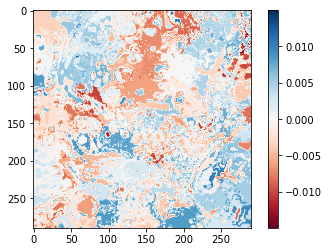

In [5]:
images = transform_img_fn([os.path.join('Trainimg_breast_2_299','0072img.tif')])
print(pred_label(images))

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(images[0].astype('double'), combine_model_predict, segmentation_fn= None, top_labels=3, num_samples=100)
temp, mask = explanation.get_image_and_mask(0, positive_only=False, num_features=100, hide_rest=True)
dict_heatmap = dict(explanation.local_exp[explanation.top_labels[0]])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()